Location Testing and TensorFlow Installation Testing

In [33]:
import sys, pathlib, importlib


def find_project_root(start: pathlib.Path, max_up=5):
    p = start
    for _ in range(max_up):
        if (p / "models" / "cnn").exists():
            return p
        p = p.parent
    return start  

NOTEBOOK_DIR = pathlib.Path().resolve()
PROJECT_ROOT = find_project_root(NOTEBOOK_DIR)

if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

print("✓ Notebook dir:", NOTEBOOK_DIR)
print("✓ Project root:", PROJECT_ROOT)
print("✓ models/cnn exists:", (PROJECT_ROOT / "models" / "cnn").exists())

tf_spec = importlib.util.find_spec("tensorflow")
if tf_spec is None:
    print("⚠️ TensorFlow not found — install it with one of the lines at the top and re-run this cell.")
else:
    import tensorflow as tf
    print("✓ TensorFlow version:", tf.__version__)
    try:
        gpus = tf.config.list_physical_devices('GPU')
        print("GPUs available:", gpus if gpus else "None (CPU mode)")
    except Exception as e:
        print("GPU check error:", e)


✓ Notebook dir: D:\_4TH_YEAR_1ST_SEMESTER_STUFF\DL\DL Final Assignment\Seismic-GNN-Prediction\notebooks
✓ Project root: D:\_4TH_YEAR_1ST_SEMESTER_STUFF\DL\DL Final Assignment\Seismic-GNN-Prediction
✓ models/cnn exists: True
✓ TensorFlow version: 2.17.1
GPUs available: None (CPU mode)


Checking for Cached Arrays and Fallback CSVs

In [34]:
from importlib import reload
import models.cnn.config as cfg
reload(cfg)

print("Looking for pre-exported arrays from your notebooks:")
for k, path in cfg.Xy_FILES.items():
    print(f"  {k:8s} -> {path}  {'✓' if path.exists() else '✗'}")

print("\nFallback single table (used to rebuild 50×50×1):")
print(" ", cfg.FALLBACK_DATA, " ", "✓" if cfg.FALLBACK_DATA.exists() else "✗")
print("Expect columns:", cfg.TIME_COL, cfg.LAT_COL, cfg.LON_COL, cfg.MAG_COL)


Looking for pre-exported arrays from your notebooks:
  X_train  -> D:\_4TH_YEAR_1ST_SEMESTER_STUFF\DL\DL Final Assignment\Seismic-GNN-Prediction\data\processed\model_ready\X_train_cnn.npy  ✓
  y_train  -> D:\_4TH_YEAR_1ST_SEMESTER_STUFF\DL\DL Final Assignment\Seismic-GNN-Prediction\data\processed\model_ready\y_train_cnn.npy  ✓
  X_val    -> D:\_4TH_YEAR_1ST_SEMESTER_STUFF\DL\DL Final Assignment\Seismic-GNN-Prediction\data\processed\model_ready\X_val_cnn.npy  ✓
  y_val    -> D:\_4TH_YEAR_1ST_SEMESTER_STUFF\DL\DL Final Assignment\Seismic-GNN-Prediction\data\processed\model_ready\y_val_cnn.npy  ✓
  X_test   -> D:\_4TH_YEAR_1ST_SEMESTER_STUFF\DL\DL Final Assignment\Seismic-GNN-Prediction\data\processed\model_ready\X_test_cnn.npy  ✓
  y_test   -> D:\_4TH_YEAR_1ST_SEMESTER_STUFF\DL\DL Final Assignment\Seismic-GNN-Prediction\data\processed\model_ready\y_test_cnn.npy  ✓

Fallback single table (used to rebuild 50×50×1):
  D:\_4TH_YEAR_1ST_SEMESTER_STUFF\DL\DL Final Assignment\Seismic-GNN-Predic

Rebuild 50×50 density-only windows

In [35]:
import importlib, models.cnn.data as data
importlib.reload(data)  # ensure latest code

X_train, y_train, X_val, y_val, X_test, y_test = data.load_data(force_rebuild=True)
print("X_train:", X_train.shape, "| y_train:", y_train.shape)
print("X_val:  ", X_val.shape,   "| y_val:", y_val.shape)
print("X_test: ", X_test.shape,  "| y_test:", y_test.shape)

if X_train.shape[1:3] != (50,50) or X_train.shape[-1] != 1:
    print("⚠️ Not 50×50×1 — check cfg.GRID_SIZE=50, DENSITY_ONLY=True, and that FALLBACK_DATA CSV exists & columns match.")


X_train: (1159, 50, 50, 1) | y_train: (1159,)
X_val:   (248, 50, 50, 1) | y_val: (248,)
X_test:  (250, 50, 50, 1) | y_test: (250,)


Overwrite the cached arrays

In [36]:
from pathlib import Path
import numpy as np

outdir = cfg.PROCESSED
outdir.mkdir(parents=True, exist_ok=True)

np.save(outdir / "X_train_cnn.npy", X_train)
np.save(outdir / "y_train_cnn.npy", y_train)
np.save(outdir / "X_val_cnn.npy",   X_val)
np.save(outdir / "y_val_cnn.npy",   y_val)
np.save(outdir / "X_test_cnn.npy",  X_test)
np.save(outdir / "y_test_cnn.npy",  y_test)

print("✓ Saved 50×50×1 arrays to", outdir)


✓ Saved 50×50×1 arrays to D:\_4TH_YEAR_1ST_SEMESTER_STUFF\DL\DL Final Assignment\Seismic-GNN-Prediction\data\processed\model_ready


Train the CNN

utils has: ['ensure_dir', 'plot_learning_curves']


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 50, 50, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 50, 50, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 25, 25, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 25, 25, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         9,217 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,033 (109.50 KB)

 Trainable params: 28,033 (109.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 1.9189 - mae: 1.9189 - mse: 5.2328 - r2_metric: -2258.5637 - val_loss: 0.4964 - val_mae: 0.4964 - val_mse: 0.4709 - val_r2_metric: -140.7040 - learning_rate: 0.0010
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.5417 - mae: 0.5417 - mse: 0.5259 - r2_metric: -202.7260 - val_loss: 0.5364 - val_mae: 0.5364 - val_mse: 0.4358 - val_r2_metric: -171.0591 - learning_rate: 0.0010
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.3953 - mae: 0.3953 - mse: 0.2846 - r2_metric: -111.2747 - val_loss: 0.4256 - val_mae: 0.4256 - val_mse: 0.3559 - val_r2_metric: -109.9389 - learning_rate: 0.0010
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.3327 - mae: 0.3327 - mse: 0.2212 - r2_metric: -85.8979 - val_loss: 0.3870 - val_mae: 0.3870 - val_mse: 0.2977 - val_r2_metric: -97.7717 - learning_rate: 0.0010
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.3084 - mae: 0.3084 - mse: 0.2015 - r2_metri

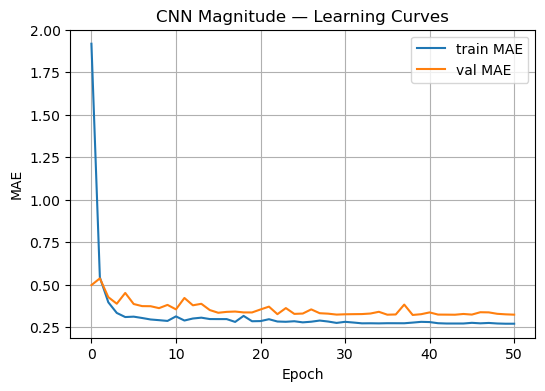

Test metrics: {'loss': 0.3892689347267151, 'mae': 0.3892689347267151, 'mse': 0.2860986590385437, 'r2_metric': -115.64459991455078}


In [37]:
import sys, importlib, shutil, pathlib

# ensure project root is first on sys.path (parent of 'models')
from pathlib import Path
NOTEBOOK_DIR = Path().resolve()
PROJECT_ROOT = NOTEBOOK_DIR if (NOTEBOOK_DIR / "models" / "cnn").exists() else NOTEBOOK_DIR.parent
sys.path.insert(0, str(PROJECT_ROOT))

# remove pycache
shutil.rmtree(Path("models/cnn/__pycache__"), ignore_errors=True)
# drop cached modules
for mod in ["models.cnn.utils", "models.cnn.train"]:
    sys.modules.pop(mod, None)

import models.cnn.utils as u
importlib.reload(u)
print("utils has:", [n for n in ("ensure_dir","plot_learning_curves") if hasattr(u, n)])

import models.cnn.train as t
importlib.reload(t)
from models.cnn.train import main as train_main

train_main()
